In [2]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team3/anaconda3/envs/gpu/lib/python3.7/site-packages

In [3]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

Using TensorFlow backend.


<h2>Data Loading and Preparation</h2>

In [4]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [5]:
image_folder_path = '../data/SpectogramInitial'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [6]:
X_all = []
Y_all = []

image_folder_path = '../data/STFT'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112)) 
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [7]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [8]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [12]:
## vary the #of filters in each conv layer
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        bt = BatchNormalization()(c1)
        bt = Activation('relu')(bt)
        mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.2)(mpool)


        c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(0.3)(mpool)

        c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c2)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.3)(mpool)

        c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
        bt = BatchNormalization()(c3)
        bt = Activation('relu')(bt)

        mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
        mpool = Dropout(rate=0.4)(mpool)

        lay = Flatten()(mpool)
        
        for i in range(hp.Int(name='dense_layers', min_value=0, max_value=3, step=1)):

            lay = Dense(hp.Choice(name= "units_"+str(i),values=(48,56,64,112,128,256,512)))(lay)
            lay = BatchNormalization()(lay)
            lay = Activation('relu')(lay)
            lay = Dropout(0.4)(lay)


        x_out = Dense(8, name='output', activation='softmax')(lay)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model


In [13]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [14]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4759 - acc: 0.5327 - val_loss: 2.5351 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 3s - loss: 1.1102 - acc: 0.5990 - val_loss: 1.7215 - val_acc: 0.4463
Epoch 3/70
2172/2172 - 3s - loss: 1.0039 - acc: 0.6354 - val_loss: 1.4877 - val_acc: 0.5124
Epoch 4/70
2172/2172 - 3s - loss: 0.8737 - acc: 0.6934 - val_loss: 11.9216 - val_acc: 0.0083
Epoch 5/70
2172/2172 - 3s - loss: 0.7000 - acc: 0.7528 - val_loss: 0.8950 - val_acc: 0.7231
Epoch 6/70
2172/2172 - 3s - loss: 0.6010 - acc: 0.7891 - val_loss: 1.1511 - val_acc: 0.6116
Epoch 7/70
2172/2172 - 3s - loss: 0.5403 - acc: 0.8112 - val_loss: 7.5882 - val_acc: 0.1942
Epoch 8/70
2172/2172 - 3s - loss: 0.4936 - acc: 0.8287 - val_loss: 0.8554 - val_acc: 0.6942
Epoch 9/70
2172/2172 - 3s - loss: 0.4656 - acc: 0.8384 - val_loss: 1.1343 - val_acc: 0.6281
Epoch 10/70
2172/2172 - 3s - loss: 0.3726 - acc: 0.8679 - val_loss: 1.5110 - val_acc: 0.5826
Epoch 11/70
2172/2172 - 3s - lo

Epoch 19/70
2172/2172 - 3s - loss: 0.2287 - acc: 0.9231 - val_loss: 0.3456 - val_acc: 0.8802
Epoch 20/70
2172/2172 - 3s - loss: 0.1925 - acc: 0.9351 - val_loss: 1.0067 - val_acc: 0.6570
Epoch 21/70
2172/2172 - 3s - loss: 0.2263 - acc: 0.9199 - val_loss: 0.5855 - val_acc: 0.8223
Epoch 22/70
2172/2172 - 3s - loss: 0.1940 - acc: 0.9342 - val_loss: 0.4186 - val_acc: 0.8719
Epoch 23/70
2172/2172 - 3s - loss: 0.2063 - acc: 0.9282 - val_loss: 1.3379 - val_acc: 0.6488
Epoch 24/70
2172/2172 - 3s - loss: 0.2029 - acc: 0.9305 - val_loss: 0.5728 - val_acc: 0.7727
Epoch 25/70
2172/2172 - 3s - loss: 0.1910 - acc: 0.9342 - val_loss: 0.1952 - val_acc: 0.9050
Epoch 26/70
2172/2172 - 3s - loss: 0.1899 - acc: 0.9355 - val_loss: 0.4880 - val_acc: 0.8388
Epoch 27/70
2172/2172 - 3s - loss: 0.1693 - acc: 0.9406 - val_loss: 0.2443 - val_acc: 0.9215
Epoch 28/70
2172/2172 - 3s - loss: 0.1582 - acc: 0.9475 - val_loss: 0.2673 - val_acc: 0.9091
Epoch 29/70
2172/2172 - 3s - loss: 0.1324 - acc: 0.9540 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 4s - loss: 1.7300 - acc: 0.4715 - val_loss: 1.5332 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 3s - loss: 1.5296 - acc: 0.5322 - val_loss: 1.4222 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 3s - loss: 1.4649 - acc: 0.5470 - val_loss: 1.4051 - val_acc: 0.5744
Epoch 4/70
2172/2172 - 3s - loss: 1.3698 - acc: 0.5576 - val_loss: 1.6895 - val_acc: 0.5868
Epoch 5/70
2172/2172 - 3s - loss: 1.2830 - acc: 0.5695 - val_loss: 1.6866 - val_acc: 0.5868
Epoch 6/70
2172/2172 - 3s - loss: 1.1988 - acc: 0.5829 - val_loss: 1.1284 - val_acc: 0.6322
Epoch 7/70
2172/2172 - 3s - loss: 1.1848 - acc: 0.5861 - val_loss: 1.3150 - val_acc: 0.6074
Epoch 8/70
2172/2172 - 3s - loss: 1.1460 - acc: 0.5976 - val_loss: 0.9593 - val_acc: 0.6529
Epoch 9/70
2172/2172 - 3s - loss: 1.1396 - acc: 0.5976 - val_loss: 0.9395 - val_acc: 0.6612
Epoch 10/70
2172/2172 - 3s - loss: 1.0940 - acc: 0.6110 - val_loss: 1.2981 - val_acc: 0.6157
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.8101 - acc: 0.7081 - val_loss: 0.7044 - val_acc: 0.7521
Epoch 20/70
2172/2172 - 3s - loss: 0.7999 - acc: 0.7044 - val_loss: 1.2003 - val_acc: 0.5702
Epoch 21/70
2172/2172 - 3s - loss: 0.7829 - acc: 0.7219 - val_loss: 5.8471 - val_acc: 0.1240
Epoch 22/70
2172/2172 - 3s - loss: 0.8005 - acc: 0.7247 - val_loss: 1.6510 - val_acc: 0.4256
Epoch 23/70
2172/2172 - 3s - loss: 0.7366 - acc: 0.7431 - val_loss: 0.7304 - val_acc: 0.7645
Epoch 24/70
2172/2172 - 3s - loss: 0.7579 - acc: 0.7413 - val_loss: 0.7341 - val_acc: 0.8017
Epoch 25/70
2172/2172 - 3s - loss: 0.7316 - acc: 0.7574 - val_loss: 0.8179 - val_acc: 0.6860
Epoch 26/70
2172/2172 - 3s - loss: 0.7346 - acc: 0.7477 - val_loss: 0.8384 - val_acc: 0.7397
Epoch 27/70
2172/2172 - 3s - loss: 0.7290 - acc: 0.7551 - val_loss: 0.6765 - val_acc: 0.7479
Epoch 28/70
2172/2172 - 3s - loss: 0.6927 - acc: 0.7707 - val_loss: 0.6130 - val_acc: 0.7893
Epoch 29/70
2172/2172 - 3s - loss: 0.6771 - acc: 0.7799 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5750 - acc: 0.4972 - val_loss: 1.2511 - val_acc: 0.6157
Epoch 2/70
2172/2172 - 3s - loss: 1.2299 - acc: 0.5958 - val_loss: 2.0625 - val_acc: 0.5661
Epoch 3/70
2172/2172 - 3s - loss: 1.1167 - acc: 0.6041 - val_loss: 1.4931 - val_acc: 0.5661
Epoch 4/70
2172/2172 - 3s - loss: 1.1076 - acc: 0.6169 - val_loss: 1.5882 - val_acc: 0.3843
Epoch 5/70
2172/2172 - 3s - loss: 1.0840 - acc: 0.6303 - val_loss: 1.5374 - val_acc: 0.3843
Epoch 6/70
2172/2172 - 3s - loss: 1.0090 - acc: 0.6455 - val_loss: 2.5325 - val_acc: 0.2025
Epoch 7/70
2172/2172 - 3s - loss: 0.9508 - acc: 0.6625 - val_loss: 1.0501 - val_acc: 0.6570
Epoch 8/70
2172/2172 - 3s - loss: 0.8776 - acc: 0.6915 - val_loss: 0.7127 - val_acc: 0.7438
Epoch 9/70
2172/2172 - 3s - loss: 0.8024 - acc: 0.7339 - val_loss: 0.9792 - val_acc: 0.6612
Epoch 10/70
2172/2172 - 3s - loss: 0.7594 - acc: 0.7426 - val_loss: 1.2186 - val_acc: 0.5909
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.4789 - acc: 0.8430 - val_loss: 0.3368 - val_acc: 0.8719
Epoch 20/70
2172/2172 - 3s - loss: 0.4749 - acc: 0.8425 - val_loss: 0.3942 - val_acc: 0.8430
Epoch 21/70
2172/2172 - 3s - loss: 0.4359 - acc: 0.8462 - val_loss: 0.3555 - val_acc: 0.8719
Epoch 22/70
2172/2172 - 3s - loss: 0.4501 - acc: 0.8471 - val_loss: 0.8568 - val_acc: 0.6653
Epoch 23/70
2172/2172 - 3s - loss: 0.4183 - acc: 0.8541 - val_loss: 0.2875 - val_acc: 0.8967
Epoch 24/70
2172/2172 - 3s - loss: 0.4372 - acc: 0.8522 - val_loss: 0.3320 - val_acc: 0.8884
Epoch 25/70
2172/2172 - 3s - loss: 0.4154 - acc: 0.8619 - val_loss: 0.3236 - val_acc: 0.9091
Epoch 26/70
2172/2172 - 3s - loss: 0.3981 - acc: 0.8642 - val_loss: 0.5225 - val_acc: 0.8388
Epoch 27/70
2172/2172 - 3s - loss: 0.3659 - acc: 0.8835 - val_loss: 0.2803 - val_acc: 0.8967
Epoch 28/70
2172/2172 - 3s - loss: 0.3449 - acc: 0.8909 - val_loss: 0.2708 - val_acc: 0.9215
Epoch 29/70
2172/2172 - 3s - loss: 0.4093 - acc: 0.8651 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5194 - acc: 0.5110 - val_loss: 1.5632 - val_acc: 0.6240
Epoch 2/70
2172/2172 - 3s - loss: 1.2095 - acc: 0.5787 - val_loss: 1.2455 - val_acc: 0.4835
Epoch 3/70
2172/2172 - 3s - loss: 1.0888 - acc: 0.6160 - val_loss: 1.8539 - val_acc: 0.5702
Epoch 4/70
2172/2172 - 3s - loss: 1.0236 - acc: 0.6413 - val_loss: 0.9859 - val_acc: 0.6364
Epoch 5/70
2172/2172 - 3s - loss: 0.9656 - acc: 0.6575 - val_loss: 1.7385 - val_acc: 0.4256
Epoch 6/70
2172/2172 - 3s - loss: 0.9056 - acc: 0.6929 - val_loss: 1.0911 - val_acc: 0.6116
Epoch 7/70
2172/2172 - 3s - loss: 0.8345 - acc: 0.7113 - val_loss: 0.9132 - val_acc: 0.7107
Epoch 8/70
2172/2172 - 3s - loss: 0.7840 - acc: 0.7390 - val_loss: 1.3649 - val_acc: 0.4876
Epoch 9/70
2172/2172 - 3s - loss: 0.7379 - acc: 0.7620 - val_loss: 1.1626 - val_acc: 0.6446
Epoch 10/70
2172/2172 - 3s - loss: 0.6703 - acc: 0.7753 - val_loss: 1.6208 - val_acc: 0.5372
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.4544 - acc: 0.8421 - val_loss: 0.4181 - val_acc: 0.8471
Epoch 20/70
2172/2172 - 3s - loss: 0.4507 - acc: 0.8559 - val_loss: 0.4950 - val_acc: 0.8306
Epoch 21/70
2172/2172 - 3s - loss: 0.4552 - acc: 0.8517 - val_loss: 0.4850 - val_acc: 0.8719
Epoch 22/70
2172/2172 - 3s - loss: 0.4160 - acc: 0.8587 - val_loss: 1.0318 - val_acc: 0.6736
Epoch 23/70
2172/2172 - 3s - loss: 0.4545 - acc: 0.8458 - val_loss: 0.3703 - val_acc: 0.9050
Epoch 24/70
2172/2172 - 3s - loss: 0.4150 - acc: 0.8619 - val_loss: 0.4696 - val_acc: 0.8388
Epoch 25/70
2172/2172 - 3s - loss: 0.4311 - acc: 0.8646 - val_loss: 0.4085 - val_acc: 0.8678
Epoch 26/70
2172/2172 - 3s - loss: 0.3896 - acc: 0.8642 - val_loss: 0.4050 - val_acc: 0.8636
Epoch 27/70
2172/2172 - 3s - loss: 0.3798 - acc: 0.8757 - val_loss: 0.3689 - val_acc: 0.8843
Epoch 28/70
2172/2172 - 3s - loss: 0.3802 - acc: 0.8766 - val_loss: 0.6666 - val_acc: 0.7769
Epoch 29/70
2172/2172 - 3s - loss: 0.3721 - acc: 0.8738 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.5437 - acc: 0.5087 - val_loss: 1.8427 - val_acc: 0.3719
Epoch 2/70
2172/2172 - 3s - loss: 1.2279 - acc: 0.5861 - val_loss: 1.2334 - val_acc: 0.6033
Epoch 3/70
2172/2172 - 3s - loss: 1.0966 - acc: 0.6068 - val_loss: 1.2592 - val_acc: 0.5331
Epoch 4/70
2172/2172 - 3s - loss: 1.0145 - acc: 0.6413 - val_loss: 1.2449 - val_acc: 0.4504
Epoch 5/70
2172/2172 - 3s - loss: 0.9223 - acc: 0.6768 - val_loss: 1.0697 - val_acc: 0.6240
Epoch 6/70
2172/2172 - 3s - loss: 0.8708 - acc: 0.7003 - val_loss: 0.9367 - val_acc: 0.6860
Epoch 7/70
2172/2172 - 3s - loss: 0.8139 - acc: 0.7279 - val_loss: 0.7623 - val_acc: 0.7603
Epoch 8/70
2172/2172 - 3s - loss: 0.7187 - acc: 0.7564 - val_loss: 4.9775 - val_acc: 0.1818
Epoch 9/70
2172/2172 - 3s - loss: 0.6841 - acc: 0.7693 - val_loss: 0.7663 - val_acc: 0.7521
Epoch 10/70
2172/2172 - 3s - loss: 0.6136 - acc: 0.7979 - val_loss: 0.9184 - val_acc: 0.6901
Epoch 11/70
2172/2172 - 3s - los

Epoch 19/70
2172/2172 - 3s - loss: 0.4168 - acc: 0.8600 - val_loss: 0.2947 - val_acc: 0.9008
Epoch 20/70
2172/2172 - 3s - loss: 0.4172 - acc: 0.8619 - val_loss: 0.5540 - val_acc: 0.7975
Epoch 21/70
2172/2172 - 3s - loss: 0.4124 - acc: 0.8559 - val_loss: 0.3477 - val_acc: 0.8802
Epoch 22/70
2172/2172 - 3s - loss: 0.3992 - acc: 0.8715 - val_loss: 0.3719 - val_acc: 0.8843
Epoch 23/70
2172/2172 - 3s - loss: 0.3919 - acc: 0.8697 - val_loss: 0.2937 - val_acc: 0.8967
Epoch 24/70
2172/2172 - 3s - loss: 0.3605 - acc: 0.8826 - val_loss: 1.3415 - val_acc: 0.4256
Epoch 25/70
2172/2172 - 3s - loss: 0.3574 - acc: 0.8729 - val_loss: 1.0347 - val_acc: 0.6736
Epoch 26/70
2172/2172 - 3s - loss: 0.3647 - acc: 0.8775 - val_loss: 0.3644 - val_acc: 0.8967
Epoch 27/70
2172/2172 - 3s - loss: 0.3290 - acc: 0.8913 - val_loss: 0.4231 - val_acc: 0.8884
Epoch 28/70
2172/2172 - 3s - loss: 0.3441 - acc: 0.8872 - val_loss: 0.5591 - val_acc: 0.8223
Epoch 29/70
2172/2172 - 3s - loss: 0.2917 - acc: 0.8959 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [15]:
tuner.results_summary()

In [18]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

604/604 [==============================] - ETA: 1s - loss: 0.0810 - acc: 0.968 - ETA: 0s - loss: 0.1403 - acc: 0.960 - ETA: 0s - loss: 0.1470 - acc: 0.966 - 0s 379us/sample - loss: 0.1365 - acc: 0.9669
{'dense_layers': 0}


In [21]:

best_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 85, 120)       480       
_________________________________________________________________
activation (Activation)      (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 43, 120)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 22, 96)        288096

In [22]:
accuracy

0.9668874

<h2>Evaluate Best Model</h2>

In [25]:
def build_current_model():
    inp = inp = Input(shape=(112,170,3))
    c1 = Convolution2D(filters=120 ,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    bt = BatchNormalization()(c1)
    bt = Activation('relu')(bt)
    mpool = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.2)(mpool)


    c2 = Convolution2D(filters=96,kernel_size=(5,5),strides=(2,2),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(0.3)(mpool)

    c2 = Convolution2D(filters=112,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c2)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.3)(mpool)

    c3 = Convolution2D(filters=120,kernel_size=(3,3),strides=(1,1),padding='same')(mpool)
    bt = BatchNormalization()(c3)
    bt = Activation('relu')(bt)

    mpool = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(bt)
    mpool = Dropout(rate=0.4)(mpool)

    f = Flatten()(mpool)

    x_out = Dense(8, name='output', activation='softmax')(f)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
    return model


In [26]:
model = build_current_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 85, 120)       17760     
_________________________________________________________________
batch_normalization_8 (Batch (None, 56, 85, 120)       480       
_________________________________________________________________
activation_8 (Activation)    (None, 56, 85, 120)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 43, 120)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 43, 120)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 22, 96)        2880

_________________________________________________________________
output (Dense)               (None, 8)                 5768      
Total params: 531,376
Trainable params: 530,480
Non-trainable params: 896
_________________________________________________________________


In [27]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=75,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/75
2172/2172 - 3s - loss: 1.4554 - acc: 0.5571 - val_loss: 1.3649 - val_acc: 0.5455
Epoch 2/75
2172/2172 - 3s - loss: 1.1150 - acc: 0.6142 - val_loss: 1.7598 - val_acc: 0.5165
Epoch 3/75
2172/2172 - 3s - loss: 0.9509 - acc: 0.6487 - val_loss: 1.1677 - val_acc: 0.5620
Epoch 4/75
2172/2172 - 3s - loss: 0.8169 - acc: 0.7035 - val_loss: 1.9220 - val_acc: 0.4008
Epoch 5/75
2172/2172 - 2s - loss: 0.6233 - acc: 0.7799 - val_loss: 2.6917 - val_acc: 0.4917
Epoch 6/75
2172/2172 - 3s - loss: 0.6081 - acc: 0.7896 - val_loss: 0.8333 - val_acc: 0.6901
Epoch 7/75
2172/2172 - 3s - loss: 0.4952 - acc: 0.8343 - val_loss: 0.8255 - val_acc: 0.6694
Epoch 8/75
2172/2172 - 3s - loss: 0.4643 - acc: 0.8412 - val_loss: 1.8450 - val_acc: 0.4421
Epoch 9/75
2172/2172 - 3s - loss: 0.4029 - acc: 0.8485 - val_loss: 0.6450 - val_acc: 0.7727
Epoch 10/75
2172/2172 - 3s - loss: 0.4042 - acc: 0.8582 - val_loss: 0.7485 - val_acc: 0.7066
Epoch 11/75
2172/2172 - 3s - los

Epoch 14/75
2172/2172 - 3s - loss: 0.2998 - acc: 0.8992 - val_loss: 0.3441 - val_acc: 0.8967
Epoch 15/75
2172/2172 - 3s - loss: 0.2874 - acc: 0.8918 - val_loss: 0.4898 - val_acc: 0.8347
Epoch 16/75
2172/2172 - 3s - loss: 0.2748 - acc: 0.9065 - val_loss: 0.3232 - val_acc: 0.8843
Epoch 17/75
2172/2172 - 3s - loss: 0.2521 - acc: 0.9102 - val_loss: 0.2224 - val_acc: 0.9215
Epoch 18/75
2172/2172 - 3s - loss: 0.2552 - acc: 0.9102 - val_loss: 0.3207 - val_acc: 0.9174
Epoch 19/75
2172/2172 - 3s - loss: 0.2403 - acc: 0.9121 - val_loss: 0.4628 - val_acc: 0.7975
Epoch 20/75
2172/2172 - 3s - loss: 0.2328 - acc: 0.9176 - val_loss: 0.4853 - val_acc: 0.8636
Epoch 21/75
2172/2172 - 3s - loss: 0.2134 - acc: 0.9300 - val_loss: 0.5496 - val_acc: 0.7934
Epoch 22/75
2172/2172 - 3s - loss: 0.2124 - acc: 0.9236 - val_loss: 0.6693 - val_acc: 0.7479
Epoch 23/75
2172/2172 - 3s - loss: 0.2068 - acc: 0.9309 - val_loss: 0.3048 - val_acc: 0.8926
Epoch 24/75
2172/2172 - 3s - loss: 0.1891 - acc: 0.9406 - val_loss: 0.

Epoch 27/75
2172/2172 - 3s - loss: 0.1480 - acc: 0.9452 - val_loss: 0.2100 - val_acc: 0.9298
Epoch 28/75
2172/2172 - 3s - loss: 0.1525 - acc: 0.9494 - val_loss: 0.6521 - val_acc: 0.7893
Epoch 29/75
2172/2172 - 3s - loss: 0.1395 - acc: 0.9503 - val_loss: 0.2935 - val_acc: 0.9050
Epoch 30/75
2172/2172 - 3s - loss: 0.1528 - acc: 0.9448 - val_loss: 0.1889 - val_acc: 0.9421
Epoch 31/75
2172/2172 - 3s - loss: 0.1572 - acc: 0.9406 - val_loss: 0.4786 - val_acc: 0.8388
Epoch 32/75
2172/2172 - 3s - loss: 0.1369 - acc: 0.9535 - val_loss: 0.6238 - val_acc: 0.7851
Epoch 33/75
2172/2172 - 3s - loss: 0.1469 - acc: 0.9521 - val_loss: 0.1923 - val_acc: 0.9380
Epoch 34/75
2172/2172 - 3s - loss: 0.1266 - acc: 0.9544 - val_loss: 0.3440 - val_acc: 0.8719
Epoch 35/75
2172/2172 - 2s - loss: 0.1114 - acc: 0.9613 - val_loss: 0.2470 - val_acc: 0.8967
Epoch 36/75
2172/2172 - 3s - loss: 0.1145 - acc: 0.9572 - val_loss: 0.6500 - val_acc: 0.7975
Epoch 37/75
2172/2172 - 3s - loss: 0.1024 - acc: 0.9678 - val_loss: 0.

Epoch 40/75
2173/2173 - 3s - loss: 0.1114 - acc: 0.9636 - val_loss: 0.1945 - val_acc: 0.9380
Epoch 41/75
2173/2173 - 3s - loss: 0.1324 - acc: 0.9521 - val_loss: 0.2317 - val_acc: 0.9132
Epoch 42/75
2173/2173 - 3s - loss: 0.1140 - acc: 0.9623 - val_loss: 0.2531 - val_acc: 0.9091
Epoch 43/75
2173/2173 - 3s - loss: 0.0869 - acc: 0.9655 - val_loss: 0.6014 - val_acc: 0.8264
Epoch 44/75
2173/2173 - 3s - loss: 0.0944 - acc: 0.9659 - val_loss: 0.0917 - val_acc: 0.9669
Epoch 45/75
2173/2173 - 3s - loss: 0.0936 - acc: 0.9632 - val_loss: 0.5999 - val_acc: 0.8017
Epoch 46/75
2173/2173 - 2s - loss: 0.1033 - acc: 0.9650 - val_loss: 0.8988 - val_acc: 0.7934
Epoch 47/75
2173/2173 - 3s - loss: 0.1166 - acc: 0.9632 - val_loss: 0.1751 - val_acc: 0.9339
Epoch 48/75
2173/2173 - 3s - loss: 0.0928 - acc: 0.9664 - val_loss: 0.1481 - val_acc: 0.9545
Epoch 49/75
2173/2173 - 3s - loss: 0.0881 - acc: 0.9705 - val_loss: 0.1007 - val_acc: 0.9669
Epoch 50/75
2173/2173 - 3s - loss: 0.0721 - acc: 0.9765 - val_loss: 0.

Epoch 53/75
2173/2173 - 3s - loss: 0.0711 - acc: 0.9765 - val_loss: 0.1406 - val_acc: 0.9380
Epoch 54/75
2173/2173 - 3s - loss: 0.0964 - acc: 0.9682 - val_loss: 0.4366 - val_acc: 0.8678
Epoch 55/75
2173/2173 - 3s - loss: 0.0784 - acc: 0.9747 - val_loss: 0.1791 - val_acc: 0.9421
Epoch 56/75
2173/2173 - 3s - loss: 0.0687 - acc: 0.9751 - val_loss: 0.4525 - val_acc: 0.9008
Epoch 57/75
2173/2173 - 3s - loss: 0.0950 - acc: 0.9678 - val_loss: 0.4699 - val_acc: 0.8554
Epoch 58/75
2173/2173 - 3s - loss: 0.0754 - acc: 0.9775 - val_loss: 0.2965 - val_acc: 0.8843
Epoch 59/75
2173/2173 - 3s - loss: 0.0712 - acc: 0.9751 - val_loss: 1.6273 - val_acc: 0.6818
Epoch 60/75
2173/2173 - 3s - loss: 0.0774 - acc: 0.9733 - val_loss: 0.2266 - val_acc: 0.9174
Epoch 61/75
2173/2173 - 3s - loss: 0.0590 - acc: 0.9802 - val_loss: 0.1369 - val_acc: 0.9504
Epoch 62/75
2173/2173 - 3s - loss: 0.0833 - acc: 0.9719 - val_loss: 0.1874 - val_acc: 0.9215
Epoch 63/75
2173/2173 - 3s - loss: 0.0645 - acc: 0.9784 - val_loss: 0.

In [28]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.72739375 0.7862963  0.89927974 0.94932107 0.92332301
 0.73645588 0.77777835]
precision sdev by class [0.         0.18739773 0.18898182 0.0733969  0.04574224 0.07557582
 0.10350451 0.17791372]
macro precision mean 0.8499810131092154
macro precision sdev 0.06257069651595465
recall mean [0.84       0.73233333 0.63596838 0.80954802 0.93333333 0.77638015
 0.693      0.91064815]
recall sdev [0.23323808 0.18880796 0.10669301 0.14029585 0.09612237 0.10480619
 0.18095856 0.07356603]
macro recall mean 0.7914014213248712
macro recall sdev 0.10649499681147077
f1 mean [0.89206349 0.72184465 0.68579831 0.84179236 0.93714741 0.83465309
 0.70523472 0.82253896]
f1 sdev [0.16599259 0.17621235 0.09942839 0.08236755 0.05156415 0.04232559
 0.12233557 0.11365679]
macro f1 mean 0.8051341232646531
macro f1 sdev 0.09732304391785229
accuracy mean 0.8744511438393024
accuracy sdev 0.07252370460799681


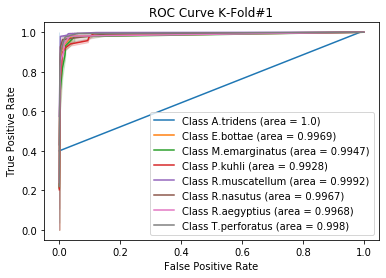

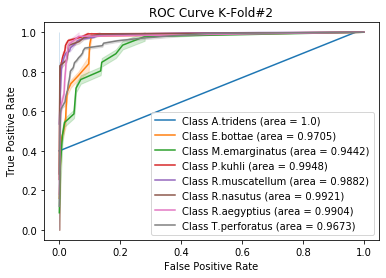

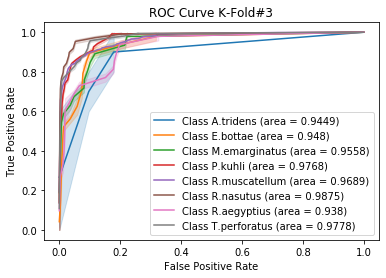

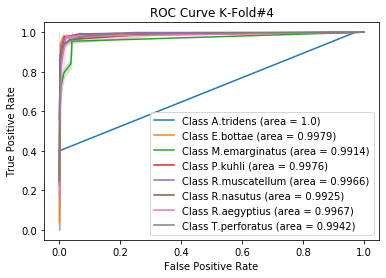

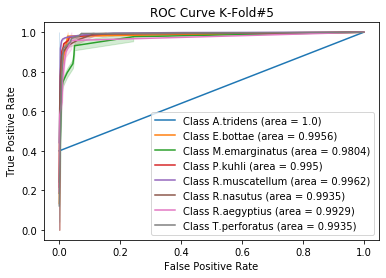

In [29]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

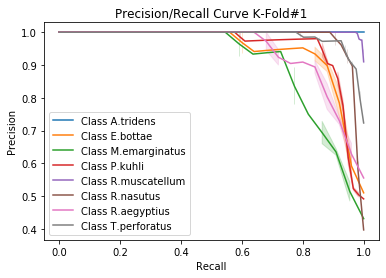

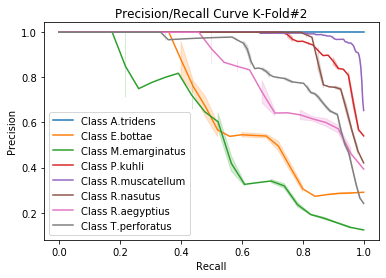

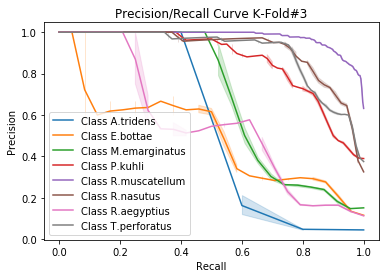

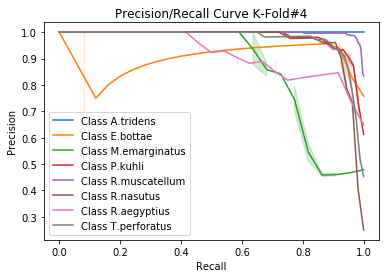

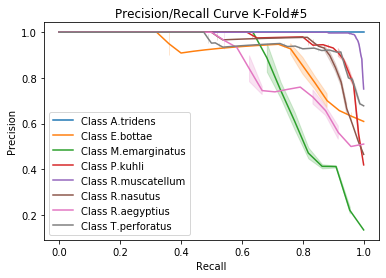

In [30]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  20   0   0   2   3   0   0]
 [  0   0  17   0   0   0   2   3]
 [  0   1   1  51   0   3   0   3]
 [  0   0   1   2 327   3   0   0]
 [  0   0   0   3   0  51   0   0]
 [  0   0   1   0   1   0  21   2]
 [  0   0   0   0   1   0   2  78]]


Confusion Matrix K-Fold #2

[[  4   0   0   0   1   0   0   0]
 [  0  12   1   0  10   0   1   1]
 [  0   0  13   0   4   0   1   5]
 [  0   0  10  34   6   0   0  10]
 [  0   0   0   0 330   0   2   1]
 [  0   6   3   0  10  33   1   0]
 [  0   0   0   0   5   0  15   4]
 [  0   0   0   0  17   0   0  64]]


Confusion Matrix K-Fold #3

[[  2   0   0   0   0   0   1   2]
 [  0  13   0   0   3   6   0   2]
 [  0   0  11   1   0   2   1   8]
 [  0   6   0  45   0   0   0   9]
 [  0   8   0   3 247   2   7  66]
 [  0   0   0   8   1  44   0   1]
 [  0   4   0   1   1   0  11   7]
 [  0   0   0   0   1   0   0  80]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

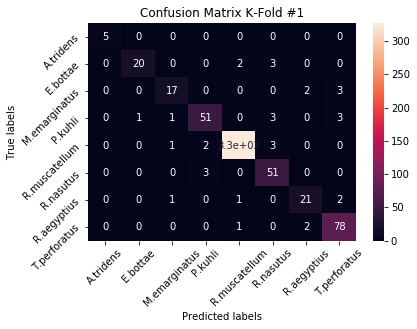

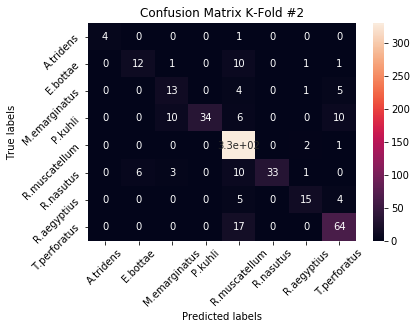

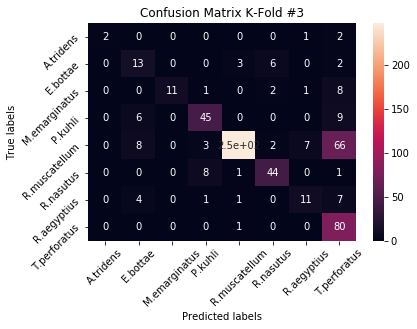

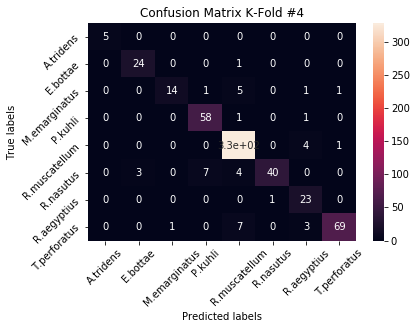

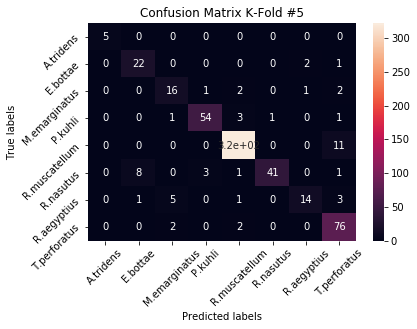

In [31]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  21    0    0    0    1    0    1    2]
 [   0   91    1    0   16    9    3    4]
 [   0    0   71    3   11    2    6   19]
 [   0    7   12  242   10    4    1   23]
 [   0    8    1    5 1554    5   13   79]
 [   0   17    3   21   16  209    1    2]
 [   0    5    6    1    8    1   84   16]
 [   0    0    3    0   28    0    5  367]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  18   0   0   3   1   0   0]
 [  0   0  14   0   2   0   1   3]
 [  0   1   2  48   2   0   0   4]
 [  0   1   0   1 310   1   2  15]
 [  0   3   0   4   3  41   0   0]
 [  0   1   1   0   1   0  16   3]
 [  0   0   0   0   5   0   1  73]]


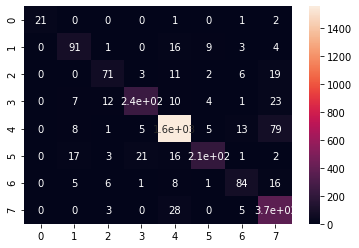

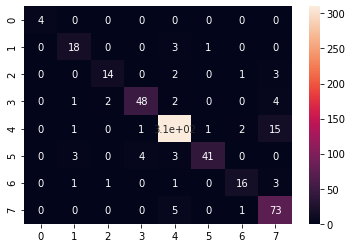

In [32]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.84 0.   0.   0.   0.04 0.   0.04 0.08]
 [0.   0.73 0.01 0.   0.13 0.07 0.02 0.03]
 [0.   0.   0.63 0.03 0.1  0.02 0.05 0.17]
 [0.   0.02 0.04 0.81 0.03 0.01 0.   0.08]
 [0.   0.   0.   0.   0.93 0.   0.01 0.05]
 [0.   0.06 0.01 0.08 0.06 0.78 0.   0.01]
 [0.   0.04 0.05 0.01 0.07 0.01 0.69 0.13]
 [0.   0.   0.01 0.   0.07 0.   0.01 0.91]]


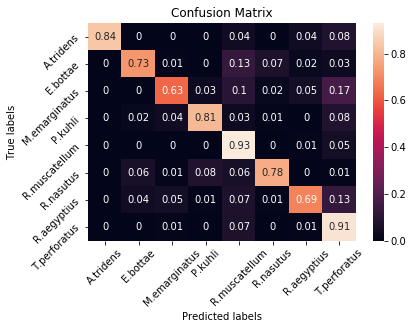

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [ ]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [ ]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [ ]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [ ]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model